In [1]:
# TensorFlow Imports
import tensorflow as tf
print(tf.__version__)

2.1.0


In [2]:
# Which GPU?
!nvidia-smi

Mon Apr 27 05:00:40 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.87.01    Driver Version: 418.87.01    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P0    28W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [ ]:
# Gather dataset
!git clone https://github.com/thunderInfy/imagenet-5-categories

In [3]:
# Other imports
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import matplotlib.pyplot as plt
from imutils import paths
import tensorflow as tf
import numpy as np
import cv2

# Random seed fixation
tf.random.set_seed(666)
np.random.seed(666)

In [4]:
# How many training images for SimCLR?
train_images = list(paths.list_images("imagenet-5-categories/train"))
print(len(train_images))

1250


In [5]:
# Augmentation utilities (differs from the original implementation)
# Referred from: https://arxiv.org/pdf/2002.05709.pdf (Appendxi A 
# corresponding GitHub: https://github.com/google-research/simclr/)

class CustomAugment(object):
    def __call__(self, sample):
        # Random crops
        h = np.random.uniform(int(0.08*tf.shape(sample)[1].numpy()), tf.shape(sample)[1].numpy(), 1) 
        w = np.random.uniform(int(0.08*tf.shape(sample)[2].numpy()), tf.shape(sample)[2].numpy(), 1)
        sample = tf.image.random_crop(sample, [1, int(h), int(w), 3])
        sample = tf.image.resize(sample, size=[224, 224])
        
        # Random flips
        sample = self._random_apply(tf.image.flip_left_right, sample, p=0.5)
        
        # randomly apply transformation (color distortions and blur) with probability p.
        sample = self._random_apply(self._color_jitter, sample, p=0.8)
        sample = self._random_apply(self._color_drop, sample, p=0.2)
        sample = self._random_apply(self._gaussian_blur, sample, p=0.5)

        return sample

    def _color_jitter(self, x, s=0.5):
        # one can also shuffle the order of following augmentations
        # each time they are applied.
        x = tf.image.random_brightness(x, max_delta=0.8*s)
        x = tf.image.random_contrast(x, lower=1-0.8*s, upper=1+0.8*s)
        x = tf.image.random_saturation(x, lower=1-0.8*s, upper=1+0.8*s)
        x = tf.image.random_hue(x, max_delta=0.2*s)
        x = tf.clip_by_value(x, 0, 1)
        return x
    
    def _color_drop(self, x):
        image = tf.image.rgb_to_grayscale(x)
        image = tf.tile(x, [1, 1, 1, 3])
        return x

    def _gaussian_blur(self, image, sigma=tf.random.uniform([], 0.1, 2.0, dtype=tf.float32),
                       padding='SAME'):
        kernel_size = image.shape[1]
        radius = tf.cast(kernel_size / 2, dtype=tf.int32)
        kernel_size = radius * 2 + 1
        
        x = tf.cast(tf.range(-radius, radius + 1), tf.float32)
        blur_filter = tf.exp(
          -tf.pow(x, 2.0) / (2.0 * tf.pow(tf.cast(sigma, tf.float32), 2.0)))
        blur_filter /= tf.reduce_sum(blur_filter)
        
        # One vertical and one horizontal filter.
        blur_v = tf.reshape(blur_filter, [kernel_size, 1, 1, 1])
        blur_h = tf.reshape(blur_filter, [1, kernel_size, 1, 1])
        num_channels = tf.shape(image)[-1]
        blur_h = tf.tile(blur_h, [1, 1, num_channels, 1])
        blur_v = tf.tile(blur_v, [1, 1, num_channels, 1])
        
        expand_batch_dim = image.shape.ndims == 3
        if expand_batch_dim:
            # Tensorflow requires batched input to convolutions, which we can fake with
            # an extra dimension.
            image = tf.expand_dims(image, axis=0)
        
        blurred = tf.nn.depthwise_conv2d(
            image, blur_h, strides=[1, 1, 1, 1], padding=padding)
        blurred = tf.nn.depthwise_conv2d(
            blurred, blur_v, strides=[1, 1, 1, 1], padding=padding)
        
        if expand_batch_dim:
            blurred = tf.squeeze(blurred, axis=0)
        
        blurred = tf.clip_by_value(blurred, 0., 1.)
        return blurred
    
    def _random_apply(self, func, x, p):
        return tf.cond(
          tf.less(tf.random.uniform([], minval=0, maxval=1, dtype=tf.float32),
                  tf.cast(p, tf.float32)),
          lambda: func(x),
          lambda: x)

In [6]:
# Data augmentation pipeline
data_augmentation = Sequential([
    Lambda(CustomAugment())
])

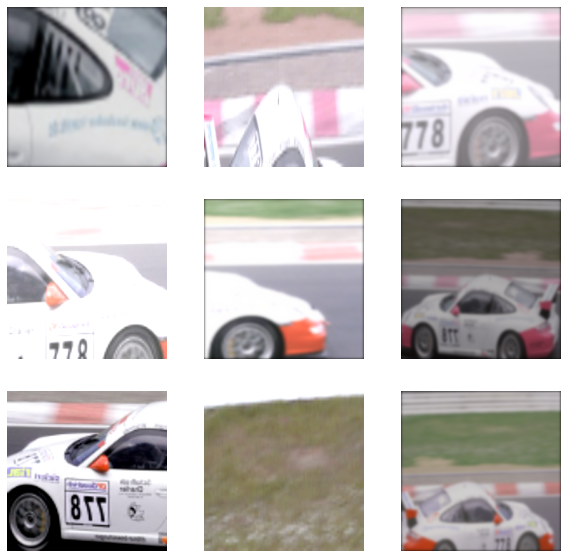

In [7]:
# Verification
idx = np.random.choice(len(train_images), 1)
sample_training_image = train_images[int(idx)]

image = plt.imread(sample_training_image)
image = cv2.resize(image, (250, 250))
image = tf.image.convert_image_dtype(image, tf.float32)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(image, 0))
    plt.imshow(augmented_image[0].numpy())
    plt.axis('off')

In [8]:
# Image preprocessing utils
def parse_images(image_path):
    image_string = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, size=[250, 250])

    return image

In [9]:
# Create TensorFlow dataset
train_ds = tf.data.Dataset.from_tensor_slices(train_images)
train_ds = (
    train_ds
    .map(parse_images, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .shuffle(1024)
    .batch(64)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

In [17]:
# Loss
# Reference: https://bit.ly/2VPrSK5
def nt_xentloss(a, b, tau=0.1):
    a_norm = tf.reshape(tf.norm(a, ord="fro", axis=(0, 1)), (-1, 1))
    a_cap = tf.divide(a, a_norm)
    b_norm = tf.reshape(tf.norm(b, ord="fro", axis=(0, 1)), (-1, 1))
    b_cap = tf.divide(b, b_norm)

    a_cap_b_cap = tf.concat([a_cap, b_cap],0)
    a_cap_b_cap_transpose = tf.transpose(a_cap_b_cap)
    b_cap_a_cap = tf.concat([b_cap,a_cap], 0)

    sim = tf.matmul(a_cap_b_cap, a_cap_b_cap_transpose)
    sim_by_tau = tf.divide(sim, tau)
    exp_sim_by_tau = tf.exp(sim_by_tau)

    sum_of_rows = tf.reduce_sum(exp_sim_by_tau, axis=1)
    exp_sim_by_tau_diag = tf.linalg.diag(exp_sim_by_tau)
    
    cs = tf.keras.metrics.CosineSimilarity()
    cs.reset_states()
    cs.update_state([a_cap_b_cap], [b_cap_a_cap])
    numerators = tf.exp(tf.divide(cs.result(), tau))
    
    denominators = sum_of_rows - exp_sim_by_tau_diag
    num_by_den = tf.divide(numerators, denominators)
    neglog_num_by_den = - tf.math.log(num_by_den)
    
    return tf.reduce_mean(neglog_num_by_den)

In [18]:
# Architecture utils
def get_resnet_simclr_deeper(hidden_1, hidden_2, hidden_3):
    base_model = tf.keras.applications.ResNet50(include_top=False, weights=None, input_shape=(224, 224, 3))
    base_model.trainabe = True
    inputs = Input((224, 224, 3))
    h = base_model(inputs, training=True)
    h = GlobalAveragePooling2D()(h)

    projection_1 = Dense(hidden_1)(h)
    projection_1 = Activation("relu")(projection_1)
    projection_2 = Dense(hidden_2)(projection_1)
    projection_2 = Activation("relu")(projection_2)
    projection_3 = Dense(hidden_3)(projection_2)

    resnet_simclr = Model(inputs, projection_3)

    return resnet_simclr

In [19]:
# Let's put our training loop inside a utility function
def train_simclr(optimizer, model, tau):
    step_wise_loss = []
    epoch_wise_loss = []

    for epoch in range(100):
        for image_batch in train_ds:
            a = data_augmentation(image_batch)
            b = data_augmentation(image_batch)

            with tf.GradientTape() as tape:
                representation_a = resnet_simclr(a)
                representation_b = resnet_simclr(b)

                loss_value = nt_xentloss(representation_a, representation_b, tau=tau)
                
            # Get gradients of loss wrt the *trainable* weights.
            gradients = tape.gradient(loss_value, model.trainable_weights)
            
            # Update the weights of the model.
            optimizer.apply_gradients(zip(gradients, model.trainable_weights))
            
            # Append step-wise loss
            step_wise_loss.append(loss_value.numpy())
        
        epoch_wise_loss.append(np.mean(step_wise_loss))
        
        if epoch % 10 == 0:
            print("epoch: {} loss: {:.3f}".format(epoch + 1, np.mean(step_wise_loss)))

    return epoch_wise_loss, model

In [20]:
get_resnet_simclr_deeper(256, 128, 50).summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               524544    
_________________________________________________________________
activation_4 (Activation)    (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               32896     
_________________________________________________________________
activation_5 (Activation)    (None, 128)               0   

epoch: 1 loss: 0.363
epoch: 11 loss: 0.461
epoch: 21 loss: 0.464
epoch: 31 loss: 0.426
epoch: 41 loss: 0.407
epoch: 51 loss: 0.395
epoch: 61 loss: 0.388
epoch: 71 loss: 0.382
epoch: 81 loss: 0.378
epoch: 91 loss: 0.376


findfont: Font family ['xkcd', 'xkcd Script', 'Humor Sans', 'Comic Neue', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.
findfont: Font family ['xkcd', 'xkcd Script', 'Humor Sans', 'Comic Neue', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.


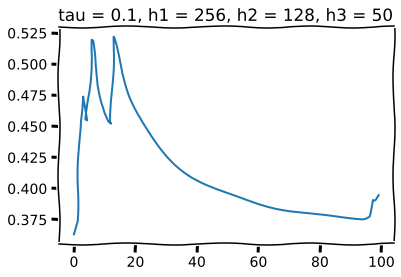

In [21]:
# Train SimCLR with SGD 
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, decay=1e-6)
resnet_simclr = get_resnet_simclr_deeper(256, 128, 50)

epoch_wise_loss, resnet_simclr  = train_simclr(optimizer, resnet_simclr, tau=0.1)

with plt.xkcd():
    plt.plot(epoch_wise_loss)
    plt.title("tau = 0.1, h1 = 256, h2 = 128, h3 = 50")
    plt.show()

In [22]:
# Serialize
# !mkdir resnet_simclr
resnet_simclr.save_weights("resnet_simclr/resnet_simclr_2_new.h5")

In [23]:
!ls -lh resnet_simclr/*.h5

-rw-r--r-- 1 jupyter jupyter 93M Apr 26 03:41 resnet_simclr/resnet_simclr_1_new.h5
-rw-r--r-- 1 jupyter jupyter 93M Apr 27 05:25 resnet_simclr/resnet_simclr_2_new.h5
